<!--
Copyright (c) 2024 - 2025 Advanced Micro Devices, Inc. All rights reserved.

See LICENSE for license information.
-->

# Trace2Tree Example Notebook

This notebook demonstrates how to navigate the tree structure created by TraceLens.

**What you'll learn:**
- Load traces using `TreePerfAnalyzer.from_file()`
- Traverse subtrees to see operation hierarchies
- Navigate parent chains to understand call stacks
- Access parent/child relationships and GPU events using tree methods

## 1. Load Trace and Build Tree

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
from pprint import pprint
from TraceLens.TreePerf import TreePerfAnalyzer
import itertools
import time
%autoreload 2

# Load trace data using TreePerfAnalyzer
# Set add_python_func=True to include Python function call stack
# This allows you to trace GPU kernels all the way back to your Python code
times = []
for i in range(10):
    trace_file = '../tests/traces/mi300_test_trace.json'
    start_time = time.time()
    mi300_analyzer = TreePerfAnalyzer.from_file(trace_file, add_python_func=True)
    end_time = time.time()
    total_time = end_time - start_time
    print(f'Time taken to load trace: {total_time} seconds\n')
    times.append(total_time)
    # Access the underlying tree structure
    mi300_tree = mi300_analyzer.tree

    print(f'Loaded {len(mi300_tree.events)} events')
    

# trace_file = '../tests/traces/h100_test_trace.json'
# h100_analyzer = TreePerfAnalyzer.from_file(trace_file, add_python_func=True)

# # Access the underlying tree structure
# h100_tree = h100_analyzer.tree

# print(f'Loaded {len(h100_tree.events)} events')

Building tree with add_python_func=True
Building CPU op tree with add_python_func=True
Caching nn.Module stack

Time taken to cache stack: 0.10435056686401367 seconds
Time taken to load trace: 16.280266046524048 seconds

Loaded 386960 events
Building tree with add_python_func=True
Building CPU op tree with add_python_func=True
Caching nn.Module stack

Time taken to cache stack: 0.22162103652954102 seconds
Time taken to load trace: 19.145191431045532 seconds

Loaded 386960 events
Building tree with add_python_func=True
Building CPU op tree with add_python_func=True
Caching nn.Module stack

Time taken to cache stack: 0.10744023323059082 seconds
Time taken to load trace: 19.218219757080078 seconds

Loaded 386960 events
Building tree with add_python_func=True
Building CPU op tree with add_python_func=True
Caching nn.Module stack

Time taken to cache stack: 0.11248302459716797 seconds
Time taken to load trace: 18.29059934616089 seconds

Loaded 386960 events
Building tree with add_python_fun

In [15]:
after_times = times

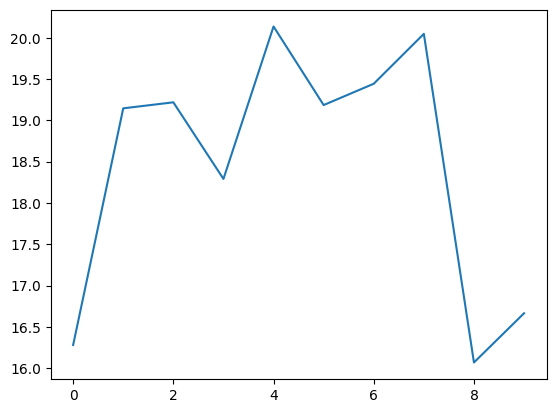

In [16]:
import matplotlib.pyplot as plt
plt.plot(times)
plt.show()

## 2. Find an Operation to Analyze

Let's find an operation of interest. You can change the filter to find different operations (e.g., `aten::matmul`, `aten::addmm`, `aten::layer_norm`, etc.)

In [20]:
# Find an operation (feel free to change this to any operation)
mi300_event_interest = next(
    evt for evt in mi300_tree.events 
    if evt.get('name') == 'vllm::rocm_unquantized_gemm' and evt.get('cat') == 'cpu_op'
)

print(f"Found operation: {mi300_event_interest['name']}")
print(f"Duration: {mi300_event_interest.get('dur', 0):.2f} µs")
print(f"UID: {mi300_event_interest['UID']}")

# Find an operation (feel free to change this to any operation)
h100_event_interest = next(itertools.islice(
    (evt for evt in h100_tree.events 
     if evt.get('name') == 'aten::linear' and evt.get('cat') == 'cpu_op'),
    1, None
))

print(f"Found operation: {h100_event_interest['name']}")
print(f"Duration: {h100_event_interest.get('dur', 0):.2f} µs")
print(f"UID: {h100_event_interest['UID']}")

Found operation: vllm::rocm_unquantized_gemm
Duration: 199.26 µs
UID: 393


NameError: name 'h100_tree' is not defined

In [21]:
print('MI300:')
for uid in mi300_event_interest['nn_module_stack']:
    print(mi300_tree.get_UID2event(uid))
print('\nH100:')
for uid in h100_event_interest['nn_module_stack']:
    print(h100_tree.get_UID2event(uid))


MI300:
{'ph': 'X', 'cat': 'python_function', 'name': 'nn.Module: Qwen2VisionTransformer_0', 'pid': 20129, 'tid': 20129, 'ts': 658903207985.796, 'dur': 54711.944, 'args': {'Python parent id': 7203, 'Python id': 7211, 'Python module id': 0, 'Ev Idx': 34303}, <TraceKeys.UID: 'UID'>: 34303, <TraceKeys.TimeEnd: 't_end'>: 658903262697.74, 'tree': True, 'parent': 34295, 'children': [34304], 'gpu_events': [284929, 284931, 284933, 284935, 284937, 284939, 284941, 284943, 284945, 284947, 284949, 284951, 284953, 284955, 284957, 284959, 284961, 284963, 284965, 284967, 284969, 284971, 284973, 284975, 284977, 284979, 284981, 284983, 284985, 284987, 284989, 284991, 284993, 284995, 284997, 284999, 285001, 285003, 285005, 285007, 285009, 285011, 285013, 285015, 285017, 285019, 285021, 285023, 285025, 285027, 285029, 285031, 285033, 285035, 285037, 285039, 285041, 285043, 285045, 285047, 285049, 285051, 285053, 285055, 285057, 285059, 285061, 285063, 285065, 285067, 285069, 285071, 285073, 285075, 285077

NameError: name 'h100_event_interest' is not defined

## 3. Traverse Subtree

Visualize the entire subtree rooted at this operation to see what happens beneath it. You can optionally include CPU operation details.

In [ ]:
print(f"Subtree for {event_interest['name']}:\n")
tree.traverse_subtree_and_print(event_interest)

## 4. Traverse Parent Chain

Trace back through all parent events to see the full call stack that led to this operation. You can optionally include CPU operation details like input dimensions and types.

In [ ]:
print(f"Parent chain for {event_interest['name']}:\n")
root = tree.traverse_parents_and_print(
    event_interest,
    cpu_op_fields=('Input Dims', 'Input type')
)
print(f"\nRoot event: {root['name']}")

## 5. Navigating Parent-Child Relationships

Use tree methods to directly access parent and children.

In [ ]:
# Get parent using tree method
parent_evt = tree.get_parent_event(event_interest)
if parent_evt:
    print(f"Parent: {parent_evt['name']} (cat: {parent_evt['cat']})\n")

# Get children using tree method
children = tree.get_children_events(event_interest)
print(f"Children ({len(children)}):")
for child in children[:5]:  # Show first 5
    print(f"  - {child['name']} (cat: {child['cat']})")

## 6. Exploring GPU Events

Use the `get_gpu_events()` method to see which GPU kernels this operation launches.

In [ ]:
gpu_events = tree.get_gpu_events(event_interest)
print(f"GPU kernels launched by {event_interest['name']} (total: {len(gpu_events)}):\n")
for gpu_evt in gpu_events[:5]:  # Show first 5
    print(f"  Kernel: {gpu_evt['name'][:60]}...")
    print(f"  Duration: {gpu_evt.get('dur', 0):.2f} µs\n")

## Summary

This notebook demonstrated:
- Loading traces via `TreePerfAnalyzer.from_file()` with Python stack
- `traverse_subtree_and_print()` and `traverse_parents_and_print()` to explore call hierarchies
- Using `cpu_op_fields` parameter to display input dimensions and types for CPU operations
- Using tree methods: `get_parent_event()`, `get_children_events()`, `get_gpu_events()`

For more advanced analysis, see:
- `tree_perf_example.ipynb` - Performance metrics and roofline analysis
- `trace_diff_example.ipynb` - Comparing two traces